In [ ]:
!apt-get install net-tools
!apt-get install tcpdump
!apt-get install iputils-ping
!apt-get install dnsutils
!apt-get install curl
!apt-get install tshark

In [ ]:
!pip install pyshark

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/NMDA/HW2"

Mounted at /content/drive


In [1]:
#! touch capture.sh
! mkdir captures

In [175]:
! rm captures/*

In [3]:
! bash capture.sh captures capture \
    https://www.indiatimes.com \
    https://www.washingtonpost.com \
    https://www.ndtv.com \
    https://www.cnbc.com \
    https://www.timesofindia.com \
    https://www.express.co.uk \
    https://www.rt.com \
    https://www.news18.com \
    https://www.nypost.com \
    https://www.abc.net.au


tcpdump: listening on en0, link-type EN10MB (Ethernet), snapshot length 524288 bytes
tcpdump: listening on en0, link-type EN10MB (Ethernet), snapshot length 524288 bytes
tcpdump: listening on en0, link-type EN10MB (Ethernet), snapshot length 524288 bytes
tcpdump: listening on en0, link-type EN10MB (Ethernet), snapshot length 524288 bytes
tcpdump: listening on en0, link-type EN10MB (Ethernet), snapshot length 524288 bytes
tcpdump: listening on en0, link-type EN10MB (Ethernet), snapshot length 524288 bytes
tcpdump: listening on en0, link-type EN10MB (Ethernet), snapshot length 524288 bytes
tcpdump: listening on en0, link-type EN10MB (Ethernet), snapshot length 524288 bytes
tcpdump: listening on en0, link-type EN10MB (Ethernet), snapshot length 524288 bytes
tcpdump: listening on en0, link-type EN10MB (Ethernet), snapshot length 524288 bytes


In [4]:
import pyshark
import os
import pandas as pd
import nest_asyncio

nest_asyncio.apply()

# Directory containing the pcap files
directory = 'captures'

# Initialize CONVERSATIONS dictionary
CONVERSATIONS = {'address_a': [], 'address_b': [], 'port_a': [], 'port_b': [],
                 'bytes': [], 'packets': [], 'start': [], 'duration': [], 'label': [], 'ip.proto':[], 'ip.len': [], 'frame.time': []}

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".pcap"):
        filepath = os.path.join(directory, filename)
        # Extract label from filename
        label = filename.split('-')[-1].split('.')[0].replace('httpswww', '').replace('com', '')

        # Read the pcap file using pyshark
        cap = pyshark.FileCapture(filepath)

        # Iterate over each packet in the pcap file
        for packet in cap:
            address_a = packet.ip.src
            address_b = packet.ip.dst
            port_a = packet.tcp.srcport
            port_b = packet.tcp.dstport
            packet_bytes = packet.length
            packet_timestamp = packet.sniff_time
            protocol = packet.ip.proto
            d_a = tuple([address_a, address_b, port_a, port_b])
            entry_a = hash(d_a)
            ip_len = packet.ip.len
            frame_time = packet.sniff_time.strftime("%Y-%m-%d %H:%M:%S.%f")

            d_b = tuple([address_a, address_b, port_a, port_b])
            entry_b = hash(d_b)

            if entry_a in CONVERSATIONS['start']:
                loc = CONVERSATIONS['start'].index(entry_a)
                CONVERSATIONS['bytes'][loc] += int(packet_bytes)
                CONVERSATIONS['packets'][loc] += 1
                CONVERSATIONS['duration'][loc] = (packet_timestamp - CONVERSATIONS['start'][loc]).total_seconds()
                CONVERSATIONS['ip.proto'][loc] = protocol
                CONVERSATIONS['ip.len'][loc] = ip_len
                CONVERSATIONS['frame.time'][loc] = frame_time

            elif entry_b in CONVERSATIONS['start']:
                loc = CONVERSATIONS['start'].index(entry_b)
                CONVERSATIONS['bytes'][loc] += int(packet_bytes)
                CONVERSATIONS['packets'][loc] += 1
                CONVERSATIONS['duration'][loc] = (packet_timestamp - CONVERSATIONS['start'][loc]).total_seconds()
                CONVERSATIONS['ip.proto'][loc] = protocol
                CONVERSATIONS['ip.len'][loc] = ip_len
                CONVERSATIONS['frame.time'][loc] = frame_time

            else:
                CONVERSATIONS['address_a'].append(address_a)
                CONVERSATIONS['address_b'].append(address_b)
                CONVERSATIONS['port_a'].append(port_a)
                CONVERSATIONS['port_b'].append(port_b)
                CONVERSATIONS['bytes'].append(int(packet_bytes))
                CONVERSATIONS['start'].append(packet_timestamp)
                CONVERSATIONS['packets'].append(1)
                CONVERSATIONS['duration'].append(0)
                CONVERSATIONS['label'].append(label)
                CONVERSATIONS['ip.proto'].append(protocol)
                CONVERSATIONS['ip.len'].append(ip_len)
                CONVERSATIONS['frame.time'].append(frame_time)

# Create DataFrame from CONVERSATIONS dictionary
df = pd.DataFrame(CONVERSATIONS)

# Display the DataFrame
print(df)


         address_a     address_b port_a port_b  bytes  packets  \
0     192.168.1.54   192.0.66.32  51933    443     78        1   
1      192.0.66.32  192.168.1.54    443  51933     66        1   
2     192.168.1.54   192.0.66.32  51933    443     54        1   
3     192.168.1.54   192.0.66.32  51933    443    378        1   
4      192.0.66.32  192.168.1.54    443  51933     60        1   
...            ...           ...    ...    ...    ...      ...   
3172  23.50.153.34  192.168.1.54    443  51870     66        1   
3173  192.168.1.54  23.50.153.34  51870    443     54        1   
3174  192.168.1.54  23.50.153.34  51870    443     54        1   
3175  23.50.153.34  192.168.1.54    443  51870     66        1   
3176  192.168.1.54  23.50.153.34  51870    443     54        1   

                          start  duration           label ip.proto ip.len  \
0    2024-03-25 05:38:06.730799         0          nypost        6     64   
1    2024-03-25 05:38:06.738487         0          ny

In [13]:
#much easier than looping over all packets!
df_tcp = df[df["ip.proto"]=='6']
df_flows_tcp = df_tcp.groupby(["address_a","address_b","port_a","port_b"])

#for flow, df_flow in df_flows_tcp: #flow is a tuple representing the flow, df_flow is the dataframe with all packets of the flow
 # print(flow)
 # display(df_flow)

In [14]:
df.to_csv('data/df_flows_tcp.csv', index=False)


In [15]:
def extract_features(flow,df_flow):
  #compute flow features:
  flow_features = {}
  if(flow[0].split('.')[0]=='10'):
    flow_features['direction'] = 'uplink'
  else:
    flow_features['direction'] = 'downlink'

  flow_features['num_packets'] = len(df_flow);
  pkt_sizes = df_flow['ip.len'].astype(float)
  flow_features['total_bytes'] = pkt_sizes.sum()
  flow_features['min_pkt_size'] = pkt_sizes.min()
  flow_features['max_pkt_size'] = pkt_sizes.max()
  flow_features['mean_pkt_size'] = pkt_sizes.mean()
  flow_features['std_pkt_size'] = pkt_sizes.std()
  iat = pd.to_datetime(df_flow['frame.time']).diff(1).dt.total_seconds().iloc[1:] #
  flow_features['min_iat'] = iat.min()
  flow_features['max_iat'] = iat.max()
  flow_features['mean_iat'] = iat.mean()
  flow_features['std_iat'] = iat.std()
  flow_features['dur'] = iat.sum()
  flow_features['dport'] = flow[3]
  flow_features['sport'] = flow[2]
  return flow_features

df_udp = df[df["ip.proto"]=='17']
df_tcp = df[df["ip.proto"]=='6']

#df_flows_udp = df_udp.groupby(["ip.src","ip.dst","udp.srcport","udp.dstport"])
df_flows_tcp = df_tcp.groupby(["address_a","address_b","port_a","port_b"])

for flow,df_flow in df_flows_tcp: #flow is a tuple representing the flow, df_flow is the dataframe with all packets of the flow
  flow_features = extract_features(flow,df_flow)
#   display(flow)
#   display(flow_features)




In [20]:
from os import listdir
from os.path import isfile, join
import numpy as np

path = 'data/'
tcpdumpfiles = [f for f in listdir(path) if isfile(join(path, f))]
apps = np.unique([f.split('_')[0] for f in tcpdumpfiles])
print(apps, len(apps), len(tcpdumpfiles))

dataset = pd.DataFrame()
for f in tcpdumpfiles:
  print('Processing file  ', f)
  df = pd.read_csv(join(path,f))
  df_tcp = df[df["ip.proto"]==6]
  df_flows_tcp = df_tcp.groupby(["address_a","address_b","port_a","port_b"])
  for flow,df_flow in df_flows_tcp: #flow is a tuple representing the flow, df_flow is the dataframe with all packets of the flow
    flow_features = extract_features(flow,df_flow)
    flow_features['app'] = df_flow['label'].iloc[0] 
    if(flow_features['direction']=='downlink'):
      flow_features_df = pd.DataFrame.from_dict(flow_features, orient='index').T
      dataset = pd.concat([dataset, flow_features_df], ignore_index=True)

display(dataset)
dataset.to_csv('traffic_classification_dataset.csv', index=False)

['df'] 1 1
Processing file   df_flows_tcp.csv


,direction,num_packets,total_bytes,min_pkt_size,max_pkt_size,mean_pkt_size,std_pkt_size,min_iat,max_iat,mean_iat,std_iat,dur,dport,sport,app
0,downlink,15,5864.0,40.0,1500.0,390.933333,547.124883,0.000002,0.01401,0.002216,0.004599,0.031025,51933,443,nypost
1,downlink,15,5861.0,40.0,1500.0,390.733333,547.071354,0.000003,0.015624,0.002459,0.004867,0.034429,51934,443,nypost
2,downlink,16,5903.0,40.0,1500.0,368.9375,535.671599,0.000002,0.01042,0.002054,0.003748,0.030817,51935,443,nypost
3,downlink,14,5800.0,40.0,1500.0,414.285714,559.826268,0.000001,0.012855,0.002247,0.00442,0.029216,51936,443,nypost
4,downlink,14,5799.0,40.0,1500.0,414.214286,559.873224,0.000003,0.01082,0.002766,0.004063,0.035964,51937,443,nypost
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,downlink,171,237951.0,52.0,1500.0,1391.526316,354.32264,0.000001,0.011183,0.000387,0.001379,0.065831,51951,443,abcnetau
78,downlink,173,238055.0,52.0,1500.0,1376.040462,377.807758,0.000001,0.013466,0.000406,0.001508,0.069892,51952,443,abcnetau
79,downlink,175,238158.0,52.0,1500.0,1360.902857,394.475655,0.000001,0.009605,0.000441,0.001529,0.076787,51953,443,abcnetau
80,downlink,170,237921.0,52.0,1500.0,1399.535294,348.609616,0.000001,0.028804,0.000495,0.00259,0.083727,51954,443,abcnetau


1.0


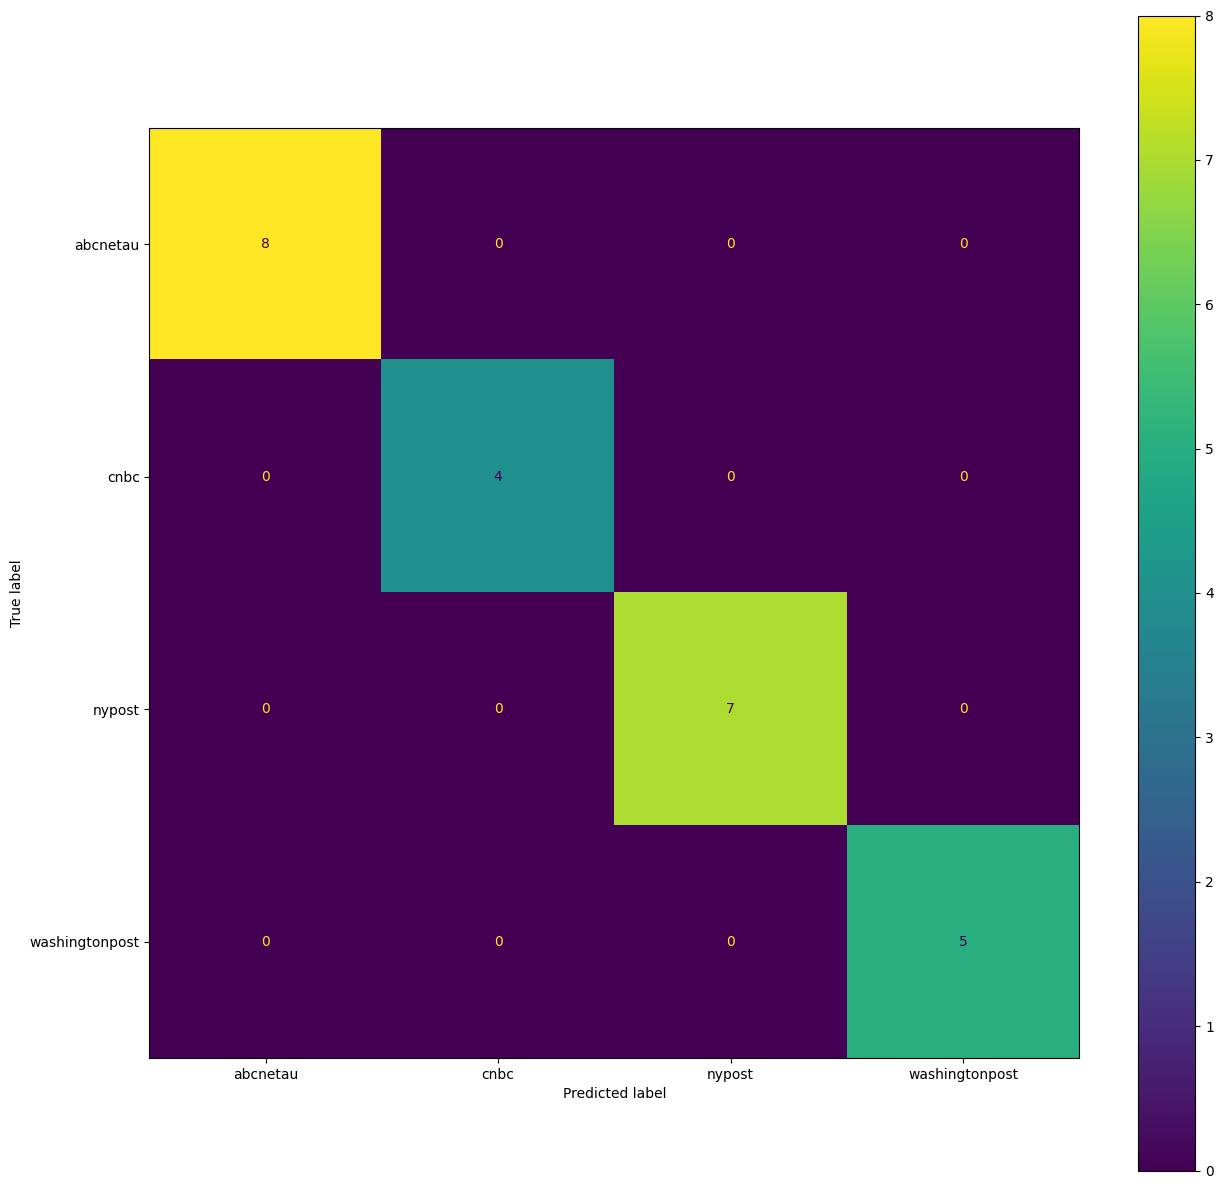

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


X = dataset.drop(['direction','sport','dport'],axis=1).dropna();
APP = X['app']
X = X.drop(['app'],axis=1)

idx = np.random.permutation(len(X))
num_train_obs = np.floor(0.7*len(X))

train_idx = idx[1:int(num_train_obs)]
test_idx = idx[int(num_train_obs):]

# normalization
X_norm = pd.DataFrame()
for key in X:
  temp = X[key]
  temp_norm = (temp-temp.mean())/temp.std();
  X_norm[key] = temp_norm

# split train / test
X_norm_train = X_norm.iloc[train_idx]
X_norm_test = X_norm.iloc[test_idx]

APP_train = APP.iloc[train_idx]
APP_test = APP.iloc[test_idx]

#K-NN classifier: for each entry in the test set, search the closest entry in the train set and assign value!
i = 0;
accuracy = 0
K = 4
APP_test_predicted = []
for index, row in X_norm_test.iterrows():
  #test_entry = row.values.tolist()
  distances = []
  for ii, rr in X_norm_train.iterrows():
    #train_entry = rr.values.tolist()
    #distances.append(np.linalg.norm(np.array(test_entry)-np.array(train_entry)))
    distances.append(np.linalg.norm(np.array(row.to_numpy() - rr.to_numpy())))

  min_idx = np.argmin(distances)

  #sorted_idx = np.argsort(distances)
  #predicted_app = APP_train.iloc[sorted_idx[1:K+1]].mode()

  predicted_app = APP_train.iloc[min_idx]
  APP_test_predicted.append(predicted_app)
  if(APP_test.iloc[i] == predicted_app):
      accuracy = accuracy+1
  i = i+1

print(accuracy/len(APP_test))
fig, ax = plt.subplots(figsize=(15, 15));
ConfusionMatrixDisplay.from_predictions(APP_test_predicted, APP_test, ax=ax);
